In [1]:
%%capture
!pip install -U seaborn

In [2]:
import os
import pandas as pd
import pickle
from nltk import tokenize
import string
import seaborn as sns
import matplotlib.pyplot as plt

### Load Data

In [3]:
file = open("stories_concat.pkl",'rb')
stories = pickle.load(file)

### Extract Text Elements

In [4]:
df = pd.DataFrame.from_dict(stories, orient = 'index', columns = ['text'])

In [5]:
def extract_summary(df):
    # find first instance of @highlight in text
    df['first_pos'] = df.text.str.find('@highlight')
    # new column for summary
    df['summary'] = df.apply(lambda row: row.text[row.first_pos:], axis = 1)
    df.summary = df.summary.str.replace('@highlight', '')
    # remove summary from text
    df.text = df.apply(lambda row: row.text[:row.first_pos], axis = 1)
    
    return df

def extract_words(df, source_var, word_var):
    df[word_var] = df[source_var].str.lower()
    df[word_var] = df[word_var].apply(lambda row: row.translate(str.maketrans('', '', string.punctuation)))
    df[word_var] = df[word_var].str.split(' ')
    
    return df

In [ ]:
# extract summary from text block
df = extract_summary(df)
df.summary = df.summary.str.strip()

# get sentences
# summary: @highlight chunks not separated by punctuation, so split by spaces and then within split by sentences
df['sentences_summary'] = df.summary.str.split('    ')
df.sentences_summary = df.sentences_summary.apply(lambda row: [tokenize.sent_tokenize(i) for i in row])
df.sentences_summary = df.sentences_summary.apply(lambda row: [item for sublist in row for item in sublist])
# text sentence tokenization using nltk
df['sentences'] = df.text.apply(lambda row: tokenize.sent_tokenize(row))

# get words without punctuation, downcased
df = extract_words(df, 'text', 'words')
df = extract_words(df, 'summary', 'words_summary')

In [ ]:
# save
with open ('cleaned_df.pkl', 'wb') as f:
    pickle.dump(df, f)

In [4]:
#file = open("stories_df.pkl",'rb')
#df = pickle.load(file)

### Distribution of Number of Sentences, Words

In [10]:
df['num_sentences'] = df.sentences.apply(lambda row: len(row))
df['num_words'] = df.words.apply(lambda row: len(row))

df['num_sentences_summary'] = df.sentences_summary.apply(lambda row: len(row))
df['num_words_summary'] = df.words_summary.apply(lambda row: len(row))

__Text__

[Text(0.5, 0, 'Number of Sentences'), Text(0.5, 1.0, 'Article Distributions')]

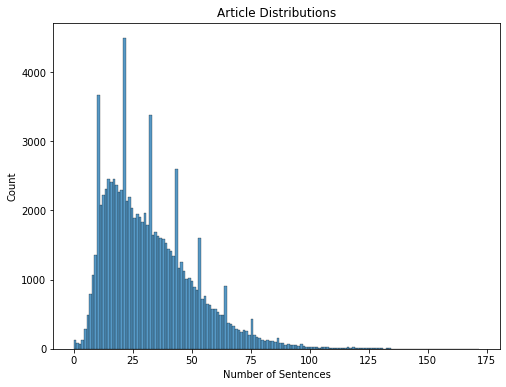

In [11]:
plt.subplots(figsize = (8,6))
ax = sns.histplot(data = df, x = 'num_sentences')
ax.set(xlabel ='Number of Sentences', title = 'Article Distributions')

[Text(0.5, 0, 'Number of Words'), Text(0.5, 1.0, 'Article Distributions')]

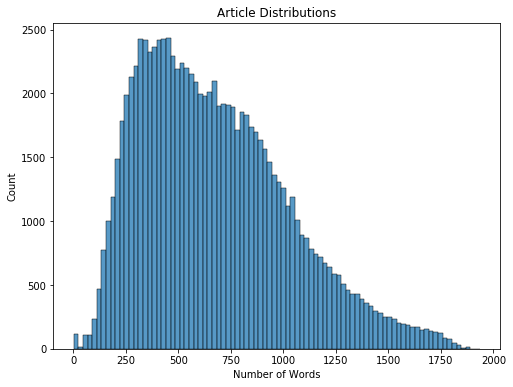

In [12]:
plt.subplots(figsize = (8,6))
ax = sns.histplot(data = df, x = 'num_words')
ax.set(xlabel ='Number of Words', title = 'Article Distributions')

__Summary__

[Text(0.5, 0, 'Number of Words'), Text(0.5, 1.0, 'Summary Distributions')]

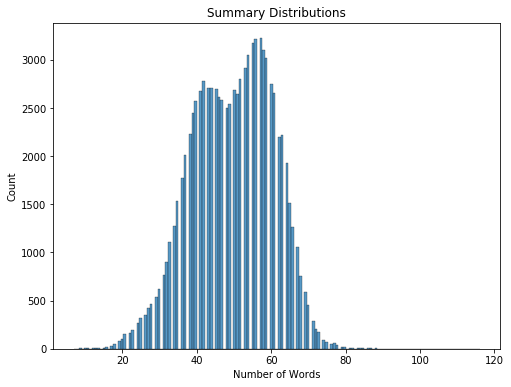

In [13]:
plt.subplots(figsize = (8,6))
ax = sns.histplot(data = df, x = 'num_words_summary')
ax.set(xlabel ='Number of Words', title = 'Summary Distributions')

[Text(0.5, 0, 'Number of Sentences'), Text(0.5, 1.0, 'Summary Distributions')]

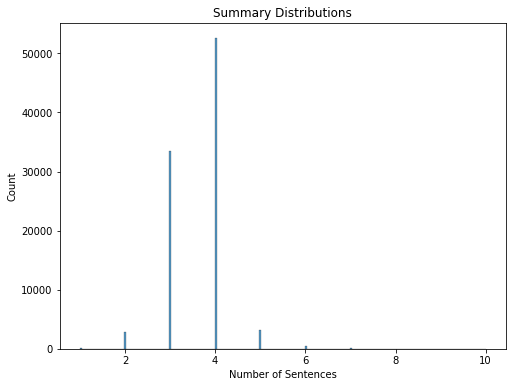

In [16]:
plt.subplots(figsize = (8,6))
ax = sns.histplot(data = df, x = 'num_sentences_summary')
ax.set(xlabel ='Number of Sentences', title = 'Summary Distributions')

### Correlation: Number Sentences/Words in Article vs Summary

In [17]:
df[['num_sentences', 'num_sentences_summary']].corr()

,num_sentences,num_sentences_summary
num_sentences,1.000000,0.203824
num_sentences_summary,0.203824,1.000000


In [18]:
df[['num_words', 'num_words_summary']].corr()

,num_words,num_words_summary
num_words,1.000000,0.270062
num_words_summary,0.270062,1.000000


### Words in Summary that don't appear in original text

In [23]:
def set_diff_words(row):
    return set(row.words_summary).difference(set(row.words))

df['new_summary_words'] = df.apply(lambda row: set_diff_words(row), axis = 1)
df['num_new_summary_words'] = df.new_summary_words.apply(lambda row: len(row))